# Shopper Spectrum: Customer Segmentation and Product Recommendations in E-Commerce

# Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Load and Preprocess Dataset

In [2]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Set file path (adjust if placed in a subfolder)
file_path = '/content/drive/MyDrive/online_retail.csv'

# STEP 3: Load and clean the dataset
import pandas as pd

df = pd.read_csv(file_path, encoding='ISO-8859-1')

df.dropna(subset=['CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(int)

df.head()


Mounted at /content/drive


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850,United Kingdom


# Step 3: Exploratory Data Analysis (EDA)

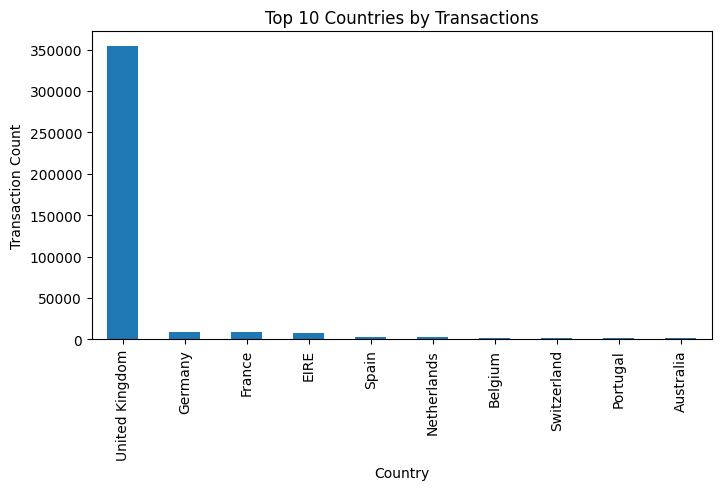

In [3]:
# Top 10 countries by transactions
top_countries = df['Country'].value_counts().head(10)
top_countries.plot(kind='bar', title='Top 10 Countries by Transactions', figsize=(8,4))
plt.ylabel('Transaction Count')
plt.show()


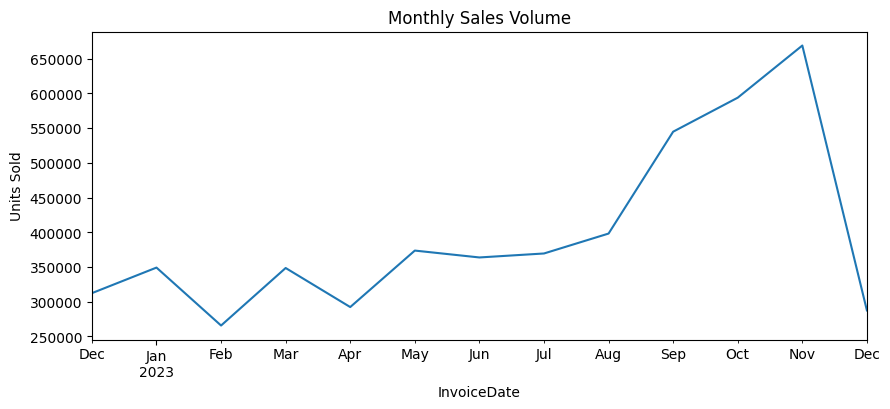

In [4]:
# Monthly sales trend
df.set_index('InvoiceDate', inplace=True)
df['Quantity'].resample('M').sum().plot(title='Monthly Sales Volume', figsize=(10,4))
plt.ylabel('Units Sold')
plt.show()
df.reset_index(inplace=True)


# Step 4: RFM Feature Engineering

In [6]:
latest_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'UnitPrice': lambda x: (x * df.loc[x.index, 'Quantity']).sum()
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]


# Step 5: Clustering Customers (KMeans)


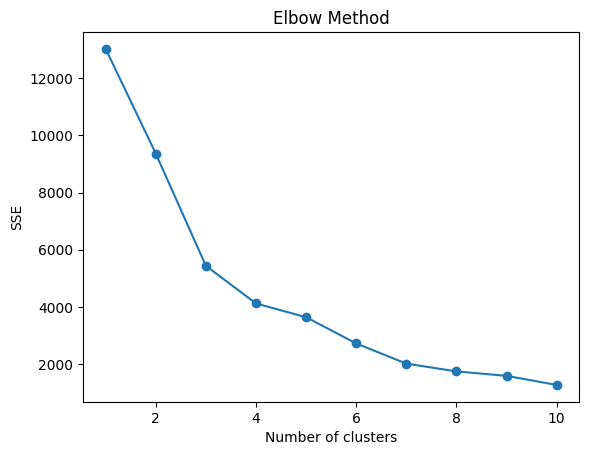

In [7]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()


In [8]:
# Fit KMeans with optimal clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# View cluster stats
rfm.groupby('Cluster').mean()


,Recency,Frequency,Monetary
Cluster,,,
0,41.412472,4.136752,1563.782438
1,246.312268,1.552974,556.665949
2,12.406250,34.739583,21702.508229
3,5.714286,65.428571,184143.690000


# Step 6: Collaborative Filtering Product Recommender

In [9]:
pivot_table = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)

product_similarity = cosine_similarity(pivot_table.T)
similarity_df = pd.DataFrame(product_similarity, index=pivot_table.columns, columns=pivot_table.columns)

def recommend_products(product_code, top_n=5):
    if product_code in similarity_df:
        return similarity_df[product_code].sort_values(ascending=False)[1:top_n+1]
    else:
        return f"Product {product_code} not found."


# Additional KPIs and Visualizations

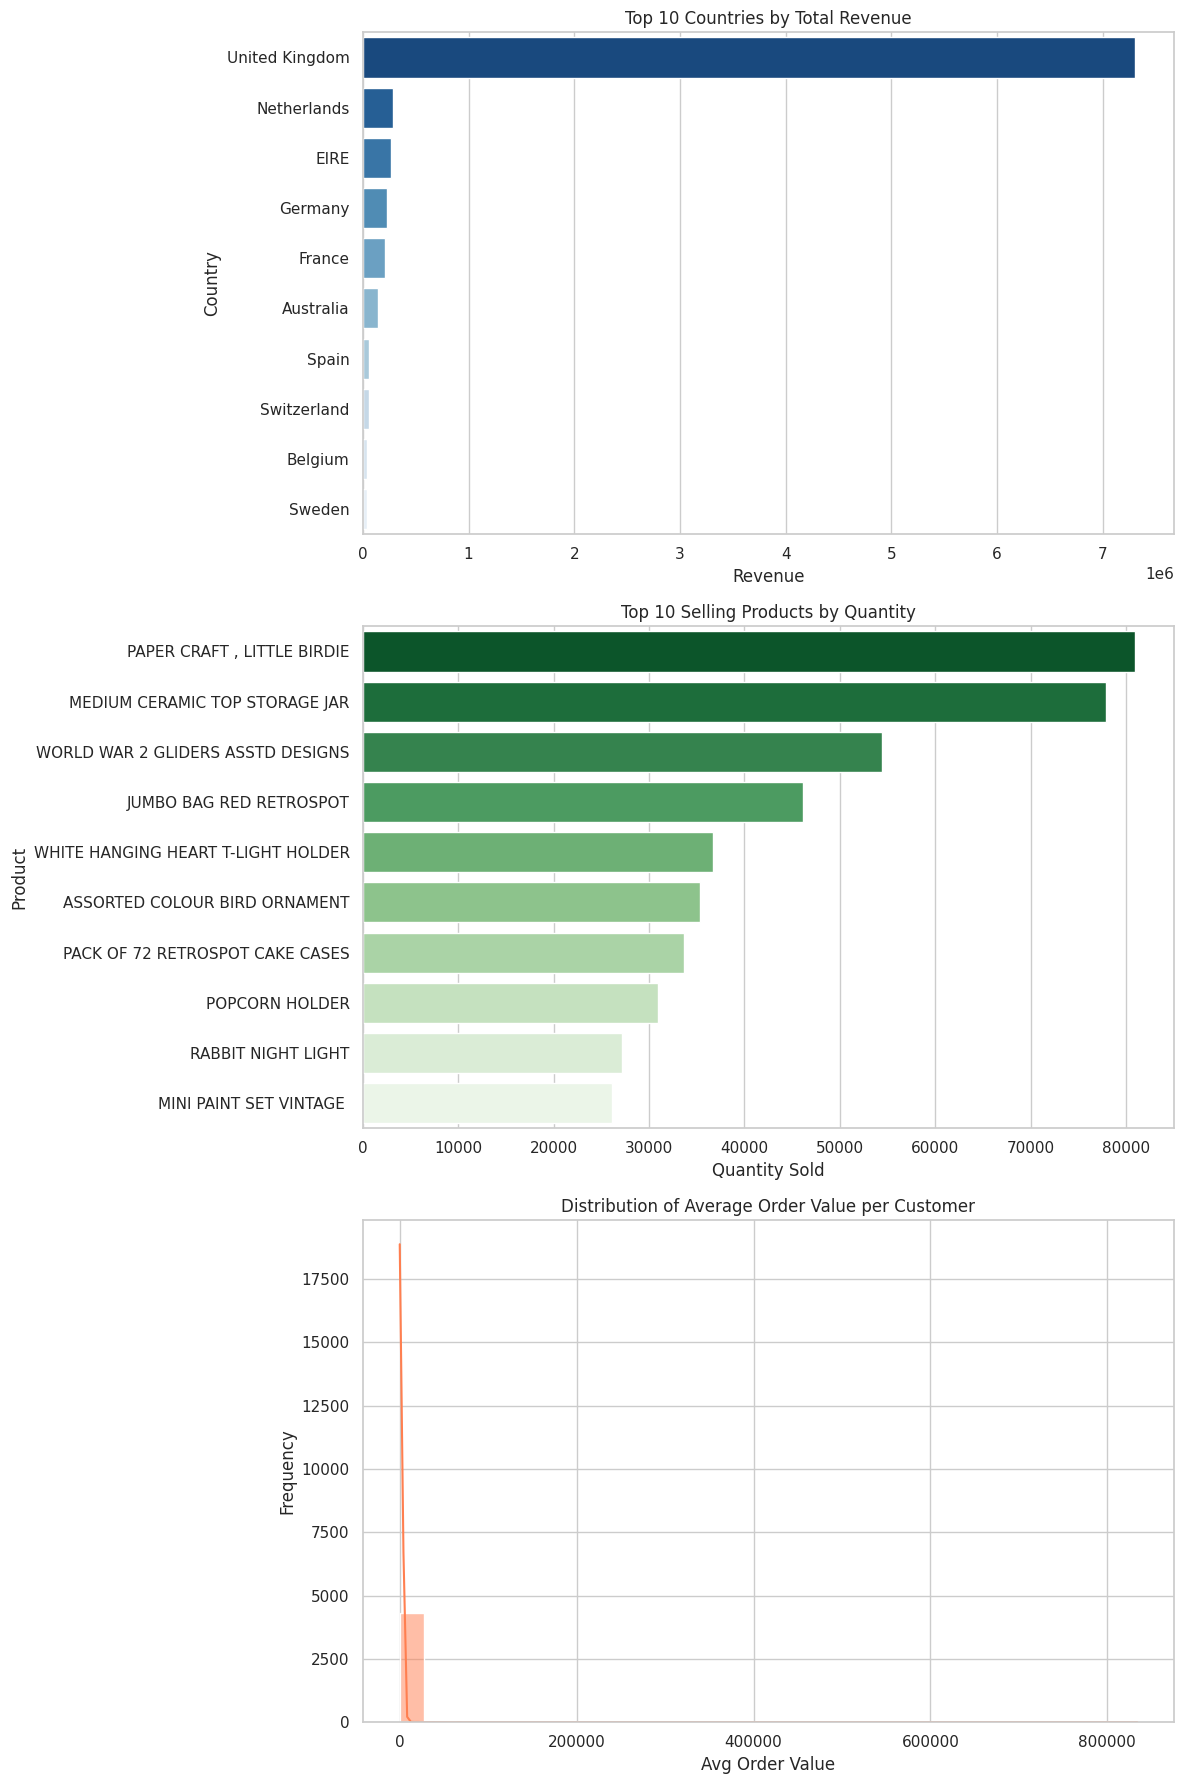

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a copy to avoid modifying the original
df_viz = df.copy()
df_viz["TotalRevenue"] = df_viz["Quantity"] * df_viz["UnitPrice"]

# Top 10 Revenue-Generating Countries
top_revenue_countries = df_viz.groupby("Country")["TotalRevenue"].sum().sort_values(ascending=False).head(10)

# Top 10 Bestselling Products by Quantity
top_products = df_viz.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)

# Average Order Value per Customer
customer_orders = df_viz.groupby("CustomerID").agg({
    "InvoiceNo": "nunique",
    "Quantity": "sum",
    "UnitPrice": "mean"
})
customer_orders["AvgOrderValue"] = (customer_orders["Quantity"] * customer_orders["UnitPrice"]) / customer_orders["InvoiceNo"]

# Plot all
sns.set(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# 1. Top Revenue Countries
sns.barplot(x=top_revenue_countries.values, y=top_revenue_countries.index, ax=axs[0], palette="Blues_r")
axs[0].set_title("Top 10 Countries by Total Revenue")
axs[0].set_xlabel("Revenue")
axs[0].set_ylabel("Country")

# 2. Top Selling Products
sns.barplot(x=top_products.values, y=top_products.index, ax=axs[1], palette="Greens_r")
axs[1].set_title("Top 10 Selling Products by Quantity")
axs[1].set_xlabel("Quantity Sold")
axs[1].set_ylabel("Product")

# 3. Average Order Value Distribution
sns.histplot(customer_orders["AvgOrderValue"], bins=30, kde=True, ax=axs[2], color="coral")
axs[2].set_title("Distribution of Average Order Value per Customer")
axs[2].set_xlabel("Avg Order Value")
axs[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# Saving the models

In [11]:
import pickle

# Example: trained models and objects
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("similarity_matrix.pkl", "wb") as f:
    pickle.dump(similarity_df, f)
